### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [8]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [9]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [11]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [12]:
from tqdm import tqdm

In [83]:
from datetime import datetime

In [13]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from [an article](https://www.science.org/doi/10.1126/science.aat8084).

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks weredesigned by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

# 1. Simulation parameters

In [14]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [15]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [16]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size_m = 8 * 1e-2  # [m]
y_layer_size_m = x_layer_size_m

In [17]:
# number of neurons in simulation
neuron_size = 400 * 1e-6  # [m]

x_layer_nodes = int(x_layer_size_m / neuron_size)
y_layer_nodes = int(y_layer_size_m / neuron_size)

In [18]:
print(f'Layer size (neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (neurons): 200 x 200 = 40000


In [19]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

In [20]:
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [21]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Train/Test datasets of images

In [22]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [23]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [24]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Train/Test datasets of wavefronts

In [25]:
# select modulation type
MODULATION_TYPE = 'amp'  # 'phase', 'amp', 'amp&phase'

In [26]:
resize_y = int(y_layer_nodes / 2)
resize_x = int(x_layer_nodes / 2)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [27]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

In [28]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [29]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [30]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


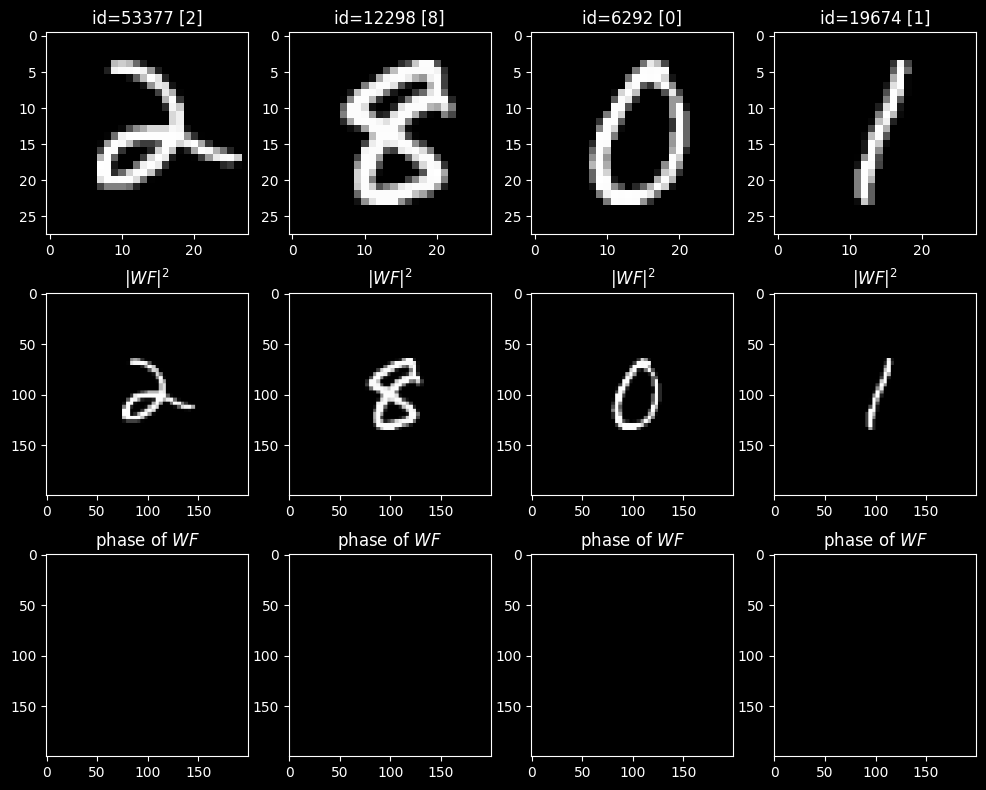

In [31]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity[0], cmap='gray',
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase[0], cmap='gray',
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# 3. Optical network

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

In [32]:
NUM_OF_DIFF_LAYERS = 5  # number of diffractive layers
FREE_SPACE_DISTANCE = 3 * 1e-2  # [m] - distance between difractive layers

## 3.1. Architecture
Figure 2A from [the article](https://www.science.org/doi/10.1126/science.aat8084).
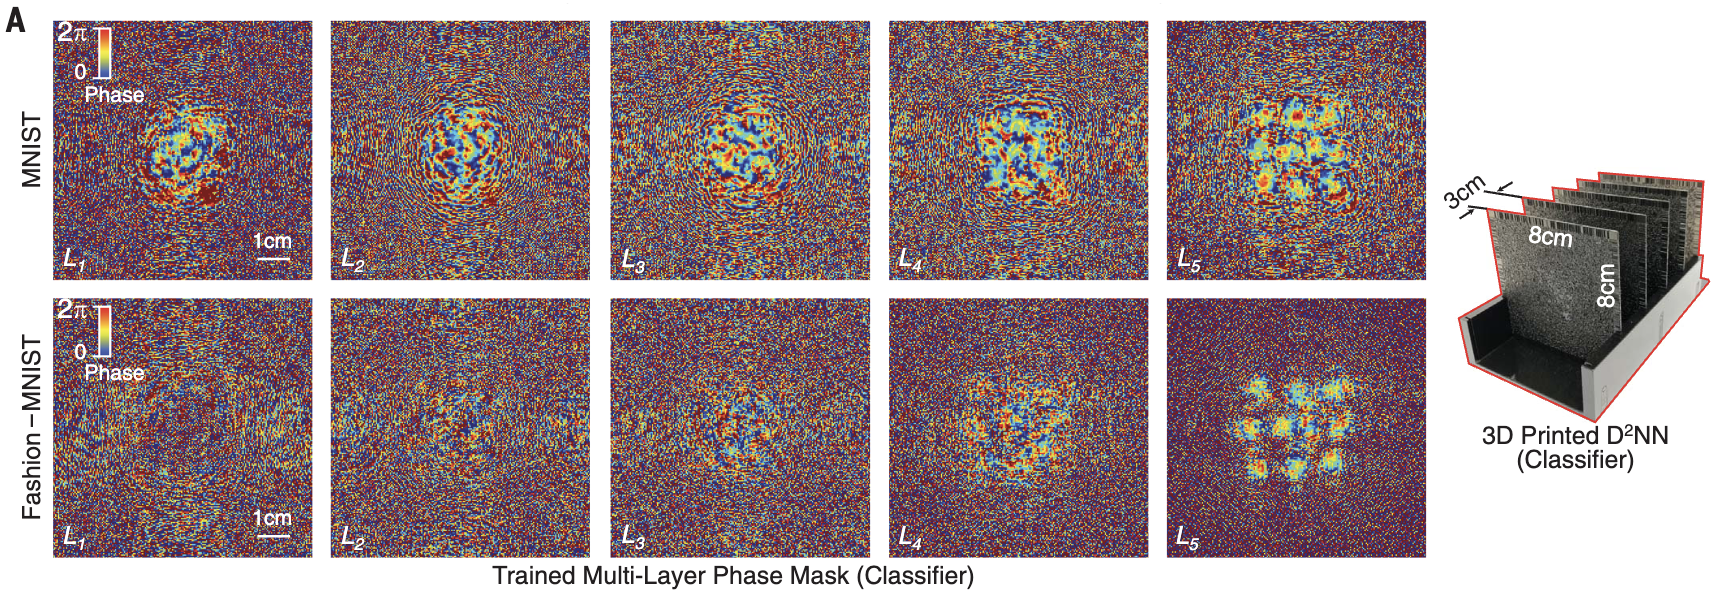

### 3.1.1. List of Elements

> To help with the 3D-printing and fabrication of the $D^2NN$ design, a sigmoid function was used to limit the phase value of each neuron to $0-2π$ and $0-π$, for imaging and classifier networks, respectively.

In [33]:
MAX_PHASE = np.pi

In [34]:
# functions that return single elements

def get_const_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_random_diffractive_layer(
    difflayer_sim_params: SimulationParameters,
    mask_seed,  # for reproducability
    max_phase=torch.pi
):
    """
    Returns DiffractiveLayer with a random (or constant if mask_seed is not int) mask.
    """
    x_nodes, y_nodes = difflayer_sim_params.axes_size(axs=('W', 'H'))

    if isinstance(mask_seed, int):
        random_mask = torch.rand(
            size=(y_nodes, x_nodes),
            generator=torch.Generator().manual_seed(mask_seed)
        ) * (max_phase)
    else:  # if not a seed -- mask is constant!
        random_mask = torch.ones(size=(y_nodes, x_nodes)) * mask_seed
    
    return elements.DiffractiveLayer(
        simulation_parameters=difflayer_sim_params,
        mask=BoundedParameter(
            random_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING BOUNDED PARAMETER!
        mask_norm=1
    )

Function to construct a list of elements:

In [35]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    masks_seeds,
):
    """
    Composes a list of elements for setup.
        Optical system: FS|DL|FS|...|FS|DL|FS|Detector
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    masks_seeds : torch.Tensor()
        Torch tensor of random seeds to generate masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements
    
    # compose architecture
    for ind_layer in range(num_layers):
        if ind_layer == 0:
            # first FreeSpace layer before first DiffractiveLayer
            elements_list.append(
                get_const_free_space(
                    simulation_parameters,  # simulation parameters for the notebook
                    FREE_SPACE_DISTANCE,  # in [m]
                    freespace_method=freespace_method,
                )
            )
    
        # add DiffractiveLayer
        elements_list.append(
            get_random_diffractive_layer(
                simulation_parameters,  # simulation parameters for the notebook
                mask_seed=masks_seeds[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # add FreeSpace
        elements_list.append(
            get_const_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )
    
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

Constants for a setup initialization:

In [36]:
FREESPACE_METHOD = 'AS'

# MASKS_SEEDS = torch.randint(
#     low=0, high=100,
#     size=(NUM_OF_DIFF_LAYERS,),
#     generator=torch.Generator().manual_seed(123)  # to generate the same set of initial masks
# )
MASKS_SEEDS = torch.ones(
    size=(NUM_OF_DIFF_LAYERS,)
) * torch.pi / 2  # to generate the set of constants masks

MASKS_SEEDS

tensor([1.5708, 1.5708, 1.5708, 1.5708, 1.5708])

In [37]:
lin_architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    masks_seeds=MASKS_SEEDS,
)  # list of elements
# Comment: Lin - a surname of the first author of the article

print(f'Number of elements in the system (including Detector): {len(lin_architecture_elements_list)}')

Number of elements in the system (including Detector): 12


### 3.1.2. Compose `LinearOpticalSetup`

In [38]:
def get_setup(simulation_parameters, num_layers):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        masks_seeds=MASKS_SEEDS,
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [39]:
lin_optical_setup = get_setup(SIM_PARAMS, NUM_OF_DIFF_LAYERS)
# Comment: Lin - a surname of the first author of the article

In [40]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer()
  (2): FreeSpace()
  (3): DiffractiveLayer()
  (4): FreeSpace()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): DiffractiveLayer()
  (8): FreeSpace()
  (9): DiffractiveLayer()
  (10): FreeSpace()
  (11): Detector()
)

#### Example of a wavefrnt propagation

In [41]:
example_wf = mnist_wf_train_ds[128][0]

In [42]:
mnist_wf_train_ds[128][1]

1

In [43]:
setup_scheme, wavefronts = lin_optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. DiffractiveLayer] -(2)-> [3. FreeSpace] -(3)-> [4. DiffractiveLayer] -(4)-> [5. FreeSpace] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. DiffractiveLayer] -(8)-> [9. FreeSpace] -(9)-> [10. DiffractiveLayer] -(10)-> [11. FreeSpace] -(11)-> [12. Detector] -(12)->


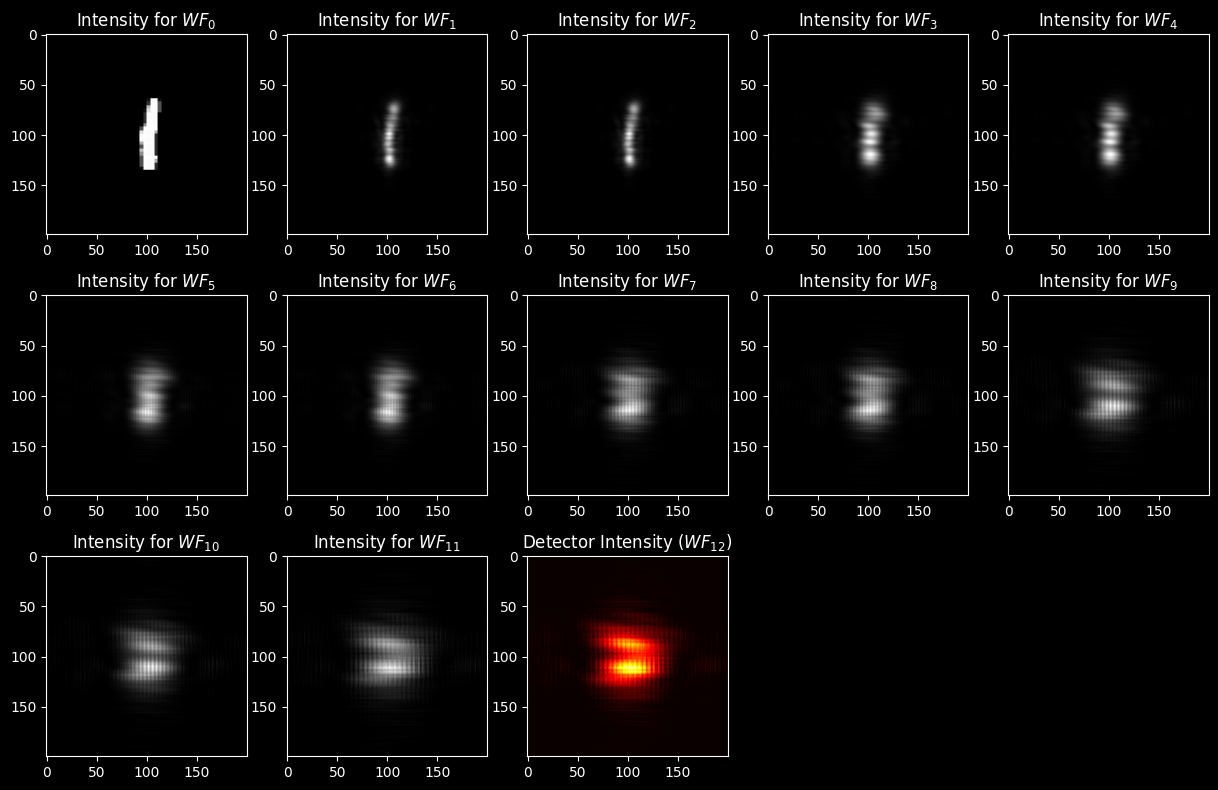

In [44]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = 3

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

### 3.1.3 Detector processor

In [45]:
number_of_classes = 10

#### Detector mask

In [46]:
# size of each segment
x_segment_nodes = int(x_layer_nodes / 9)
y_segment_nodes = int(y_layer_nodes / 9)  # each segment of size = (y_segment_nodes, x_segment_nodes)

In [47]:
# coordinates of segments left upper corners (in nodes)
segments_corners = {}

for ind, label in enumerate(range(3)):
    segments_corners[label] = (
        y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(3, 7)):
    segments_corners[label] = (
        y_layer_nodes // 2 - y_segment_nodes // 2,
        x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(7, 10)):
    segments_corners[label] = (
        3 * y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

In [48]:
# create a mask for detector
detector_mask = torch.ones(
    size=(y_layer_nodes, x_layer_nodes),
) * (-1)

for label in segments_corners.keys():
    y_node, x_node = segments_corners[label]
    detector_mask[y_node:y_node + y_segment_nodes, x_node:x_node + x_segment_nodes] = label

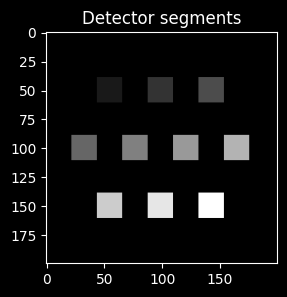

In [49]:
# let's take a look at a beam intensity distribution
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_mask, cmap='grey')

plt.show()

#### Detector processor

In [50]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    segmented_detector=detector_mask,
)

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [63]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if DEVICE == torch.device('cpu'):
#     DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

DEVICE

device(type='cpu')

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> The training batch size was set to be $8$...

In [65]:
train_bs = 8  # a batch size for training set
val_bs = 20

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [66]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [67]:
train_wf_loader = torch.utils.data.DataLoader(
        train_wf_ds,
        batch_size=train_bs,
        shuffle=True,
        # num_workers=2,
        drop_last=False,
    )

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

In [68]:
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [69]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [70]:
def onn_train_clf(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Function to train `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0
    
    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()

        # forward of an optical network
        detector_output = optical_net(batch_wavefronts)
        
        # process a detector image
        batch_probas = detector_processor_clf.batch_forward(detector_output)
        
        # calculate loss for a batch
        loss = loss_func(batch_probas, batch_labels)
        
        loss.backward()
        optimizer.step()

        # accuracy
        batch_correct_preds = (
            batch_probas.argmax(1) == batch_labels
        ).type(torch.float).sum().item()
        
        correct_preds += batch_correct_preds    
        size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_accuracies.append(batch_correct_preds / batch_size)

    epoch_accuracy = correct_preds / size
    
    return batches_losses, batches_accuracies, epoch_accuracy

In [71]:
def onn_validate_clf(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_labels = batch_labels.to(device)

        with torch.no_grad():
            detector_output  = optical_net(batch_wavefronts)
            # process a detector image
            batch_probas = detector_processor_clf.batch_forward(detector_output)
            # calculate loss for a batch
            loss = loss_func(batch_probas, batch_labels)

        # accuracy
        batch_correct_preds = (
            batch_probas.argmax(1) == batch_labels
        ).type(torch.float).sum().item()
        
        correct_preds += batch_correct_preds    
        size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_accuracies.append(batch_correct_preds / batch_size)

    epoch_accuracy = correct_preds / size
    
    return batches_losses, batches_accuracies, epoch_accuracy

## 4.2. Training of the optical network

### 4.2.1. Before training

#### Diffractive layers masks

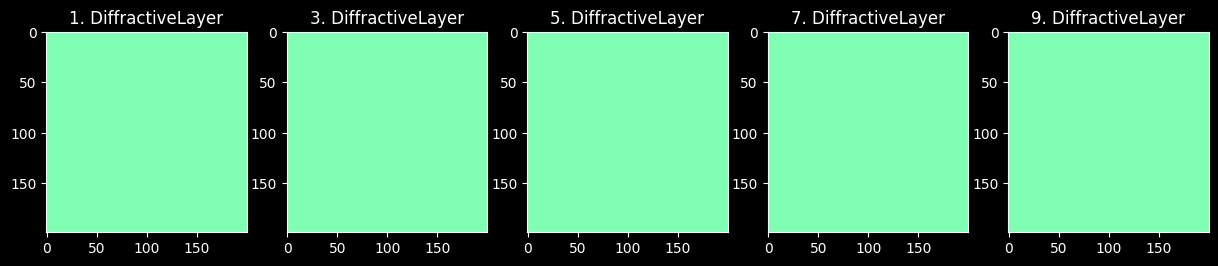

In [72]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

for ind_layer, layer in enumerate(lin_architecture_elements_list):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        ax_this.imshow(
            layer.mask.detach().numpy(), cmap='rainbow',
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()

#### Metrics for train / test datasets

In [73]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [74]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [75]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.31it/s]

Results before training on TEST set:
	CE loss : 2.321521
	Accuracy : 9.0 %


### 4.2.2. Training

In [76]:
n_epochs = 10
print_each = 1  # print each n'th epoch info

In [77]:
scheduler = None  # sheduler for a lr tuning during training 

In [78]:
# Recreate a system to restart training!

lin_optical_setup = get_setup(SIM_PARAMS, NUM_OF_DIFF_LAYERS)

# Linc optimizer to a recreated net!
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [79]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

In [80]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:45<00:00, 16.96it/s]


Training results
	CE loss : 1.947028
	Accuracy : 78.1 %
	------------   405.29 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 16.18it/s]


Validation results
	CE loss : 1.904694
	Accuracy : 82.5 %
	------------   15.46 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:11<00:00, 22.09it/s]


Training results
	CE loss : 1.891590
	Accuracy : 83.3 %
	------------   311.21 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 16.26it/s]


Validation results
	CE loss : 1.889959
	Accuracy : 82.8 %
	------------   15.38 s
Epoch #3: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:14<00:00, 21.87it/s]


Training results
	CE loss : 1.881379
	Accuracy : 83.8 %
	------------   314.32 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 15.27it/s]


Validation results
	CE loss : 1.882106
	Accuracy : 84.2 %
	------------   16.37 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:16<00:00, 21.70it/s]


Training results
	CE loss : 1.875838
	Accuracy : 84.0 %
	------------   316.83 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 15.61it/s]


Validation results
	CE loss : 1.879121
	Accuracy : 84.2 %
	------------   16.02 s
Epoch #5: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:25<00:00, 21.13it/s]


Training results
	CE loss : 1.872121
	Accuracy : 84.1 %
	------------   325.43 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 15.11it/s]


Validation results
	CE loss : 1.874838
	Accuracy : 84.1 %
	------------   16.55 s
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:36<00:00, 15.06it/s]


Training results
	CE loss : 1.869400
	Accuracy : 84.2 %
	------------   456.66 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:27<00:00,  9.07it/s]


Validation results
	CE loss : 1.872875
	Accuracy : 84.4 %
	------------   27.56 s
Epoch #7: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [09:12<00:00, 12.44it/s]


Training results
	CE loss : 1.867343
	Accuracy : 84.3 %
	------------   552.71 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:26<00:00,  9.51it/s]


Validation results
	CE loss : 1.869661
	Accuracy : 83.9 %
	------------   26.28 s
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [10:55<00:00, 10.48it/s]


Training results
	CE loss : 1.865557
	Accuracy : 84.4 %
	------------   655.95 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.19it/s]


Validation results
	CE loss : 1.868189
	Accuracy : 83.8 %
	------------   20.51 s
Epoch #9: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:56<00:00, 16.51it/s]


Training results
	CE loss : 1.864227
	Accuracy : 84.3 %
	------------   416.34 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.53it/s]


Validation results
	CE loss : 1.867513
	Accuracy : 84.9 %
	------------   18.48 s
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:56<00:00, 16.49it/s]


Training results
	CE loss : 1.862992
	Accuracy : 84.4 %
	------------   416.99 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.68it/s]

Validation results
	CE loss : 1.865699
	Accuracy : 83.9 %
	------------   19.72 s


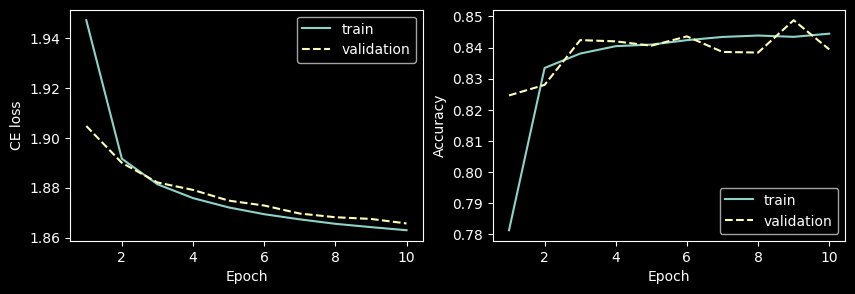

In [81]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [121]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

In [122]:
all_losses_array.T.shape

(4, 10)

### Saving

In [110]:
today_date = datetime.today().strftime('%d-%m-%Y')

RESULTS_FOLDER = (
    f'models/02_mnist_pipeline/{today_date}_' +  # date of training
    f'mnist_modulation-{MODULATION_TYPE}_' + f'resize-{resize_x}x{resize_y}_' +  # modulation type, dataset
    f'{NUM_OF_DIFF_LAYERS:02d}-diff-layers-{x_layer_nodes}x{y_layer_nodes}-or-' +
    f'{x_layer_size_m * 100:.2f}x{y_layer_size_m * 100:.2f}cm_' +  # diffractive layers size
    f'freespace-{FREESPACE_METHOD}-{FREE_SPACE_DISTANCE * 100:.2f}cm_' +
    f'epochs-{n_epochs}_' +
    f'val-acc-{(val_accuracy * 100):.1f}'
)

RESULTS_FOLDER

'models/02_mnist_pipeline/21-11-2024_mnist_modulation-amp_resize-100x100_05-diff-layers-200x200-or-8.00x8.00cm_freespace-AS-3.00cm_epochs-10_val-acc-83.9'

In [111]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [112]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [113]:
# saving model
torch.save(lin_optical_setup.net.state_dict(), model_filepath)

In [123]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

### 4.2.3. Trained masks

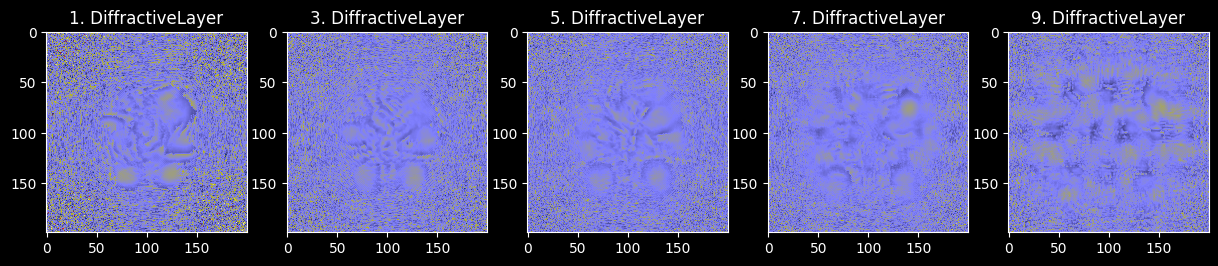

In [141]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1
cmap = 'gist_stern'

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

for ind_layer, layer in enumerate(lin_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        # mask_seed = MASKS_SEEDS[ind_diff_layer].item()
        # random_mask = torch.rand(
        #     size=(sim_params.y_nodes, sim_params.x_nodes),
        #     generator=torch.Generator().manual_seed(mask_seed)
        # ) * (MAX_PHASE)
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=1 * np.pi
        )
        ind_diff_layer += 1

plt.show()

### 4.2.4. Applying the model to an unknown data (test)

In [130]:
# list of all saved models
dir_models = 'models/02_mnist_pipeline'

filepathes = []

for file in os.listdir(dir_models):  # through files in selected directory            
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):  # looking for .txt files in the directory
        filepathes.append(filename)  # os.path.join(dir_models, filename))

print(*sorted(filepathes), sep='\n')

.DS_Store
21-11-2024_mnist_modulation-amp_resize-100x100_05-diff-layers-200x200-or-8.00x8.00cm_freespace-AS-3.00cm_epochs-10_val-acc-83.9


In [131]:
# filepath to save the model
load_model_subfolder = '21-11-2024_mnist_modulation-amp_resize-100x100_05-diff-layers-200x200-or-8.00x8.00cm_freespace-AS-3.00cm_epochs-10_val-acc-83.9'
load_model_filepath = f'{dir_models}/{load_model_subfolder}/optical_setup_net.pth'

load_model_filepath

'models/02_mnist_pipeline/21-11-2024_mnist_modulation-amp_resize-100x100_05-diff-layers-200x200-or-8.00x8.00cm_freespace-AS-3.00cm_epochs-10_val-acc-83.9/optical_setup_net.pth'

In [132]:
# setup to load weights
optical_setup_loaded = get_setup(SIM_PARAMS, NUM_OF_DIFF_LAYERS)

# LOAD WEIGHTS
optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_52064/2934183619.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optical_setup_loaded.net.load_state_dict(torc

<All keys matched successfully>

In [133]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.99it/s]

Results after training on TEST set:
	CE loss : 1.857948
	Accuracy : 85.1 %


### 4.2.5. Example of classification for a random wavefront (propagation through)

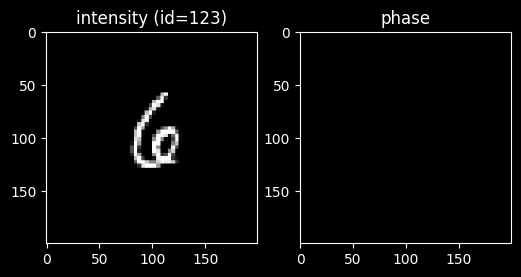

In [134]:
# plot an image
ind_test = 123

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity[0], cmap='gray')

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase[0], cmap='gray',
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [135]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

-(0)-> [1. FreeSpace] -(1)-> [2. DiffractiveLayer] -(2)-> [3. FreeSpace] -(3)-> [4. DiffractiveLayer] -(4)-> [5. FreeSpace] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. DiffractiveLayer] -(8)-> [9. FreeSpace] -(9)-> [10. DiffractiveLayer] -(10)-> [11. FreeSpace] -(11)-> [12. Detector] -(12)->


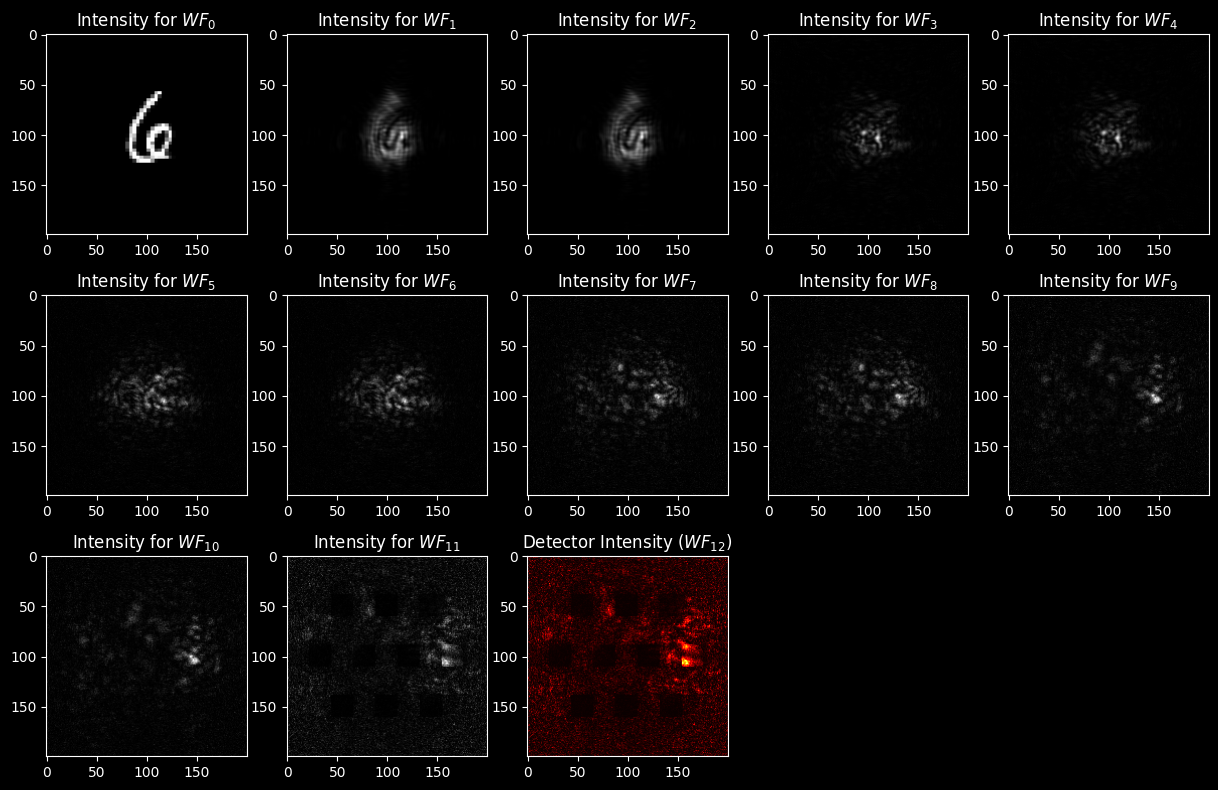

In [136]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = 3

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

In [138]:
# get probabilities of an example classification
test_probas = detector_processor.forward(test_wavefronts[-1])

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 2.71%
1 : 1.86%
2 : 5.97%
3 : 2.38%
4 : 3.49%
5 : 2.64%
6 : 74.28%
7 : 1.56%
8 : 1.90%
9 : 3.21%
